In [1]:
pip install segyio

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 82 kB 904 kB/s  eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [12]:
# pip install segyio numpy matplotlib
import segyio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ==== 配置 ====
SEGY_PATH = Path("MMT(2015)_sgy/X-9_20150928_132601_RAW_LF.sgy")   # ← 换成你的文件

# ==== 读取基础信息 ====
with segyio.open(SEGY_PATH.as_posix(), "r", ignore_geometry=True) as f:
    n_traces = f.tracecount          # 道数
    ns = f.samples.size              # 每道采样点数
    dt_us = segyio.tools.dt(f)       # 采样间隔 (微秒)
    times_ms = np.arange(ns) * (dt_us / 1000.0)  # 毫秒时间轴

    # 取第一道，画“单道波形”
    trace0 = f.trace[0].astype(np.float32)

# ---- 图 1：单道波形（time-amplitude）----
plt.figure(figsize=(7, 4))
plt.plot(times_ms, trace0)
plt.gca().invert_xaxis()  # 可选：不需要可删
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("First Trace")
plt.tight_layout()
plt.show()

# ==== 读取一段剖面（比如前 500 道） ====
n_show = min(500, n_traces)  # 道数太多先截取一些来显示
section = np.empty((ns, n_show), dtype=np.float32)

with segyio.open(SEGY_PATH.as_posix(), "r", ignore_geometry=True) as f:
    for i in range(n_show):
        section[:, i] = f.trace[i].astype(np.float32)

# 可选：做一个简单归一化，提升对比度
p99 = np.percentile(np.abs(section), 99)
if p99 > 0:
    section = np.clip(section / p99, -1, 1)

# ---- 图 2：剖面图（imshow 展示 time vs trace）----
plt.figure(figsize=(10, 6))
extent = [0, n_show, times_ms[-1], times_ms[0]]  # y 轴向下增加 → 顶部是 0 ms
plt.imshow(section, aspect='auto', extent=extent)
plt.xlabel("Trace index")
plt.ylabel("Time (ms)")
plt.title("SEGY Section (first {} traces)".format(n_show))
plt.tight_layout()
plt.show()

# ---- 额外：如果你想做“wiggle”叠线图（可选）----
def wiggle_plot(sec, tms, skip=5, scale=1.0):
    """简易 wiggle：每隔 skip 道画一条折线"""
    plt.figure(figsize=(10, 6))
    for i in range(0, sec.shape[1], skip):
        tr = sec[:, i] * scale
        plt.plot(i + tr, tms, linewidth=0.5)
        plt.fill_betweenx(tms, i, i + np.maximum(tr, 0), alpha=0.3)
    plt.gca().invert_yaxis()
    plt.xlabel("Trace index")
    plt.ylabel("Time (ms)")
    plt.title("Wiggle Plot (every {} traces)".format(skip))
    plt.tight_layout()
    plt.show()

# 使用：wiggle_plot(section, times_ms, skip=5, scale=0.5)

RuntimeError: trace count inconsistent with file size, trace lengths possibly of non-uniform

In [10]:
pip install obspy numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 14.1 MB 686 kB/s eta 0:00:01
     |████████████████████████████████| 8.5 MB 15.9 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 23.5 MB/s eta 0:00:01
     |████████████████████████████████| 8.4 MB 92.5 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 23.5 MB/s eta 0:00:01
     |████████████████████████████████| 207 kB 79.2 MB/s eta 0:00:01
     |████████████████████████████████| 70 kB 30.8 MB/s eta 0:00:01
  Created wheel for sqlalchemy: filename=SQLAlchemy-1.4.54-cp39-cp39-macosx_10_9_universal2.whl size=1588220 sha256=3f1e1636c579672689f12833791f00ec4849dd6443577c37e6c627702957feed
  Stored in directory: /Users/haonanzhang/Library/Caches/pip/wheels/76/d6/51/e82ea8caaec4f0dd1756493d8ecec6a75f49d152f7d2ede4e1
Successfully built sqlalchemy
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip inst

Trace count: 3868


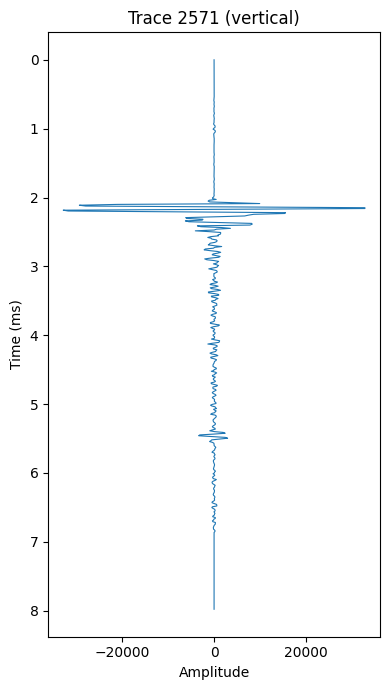

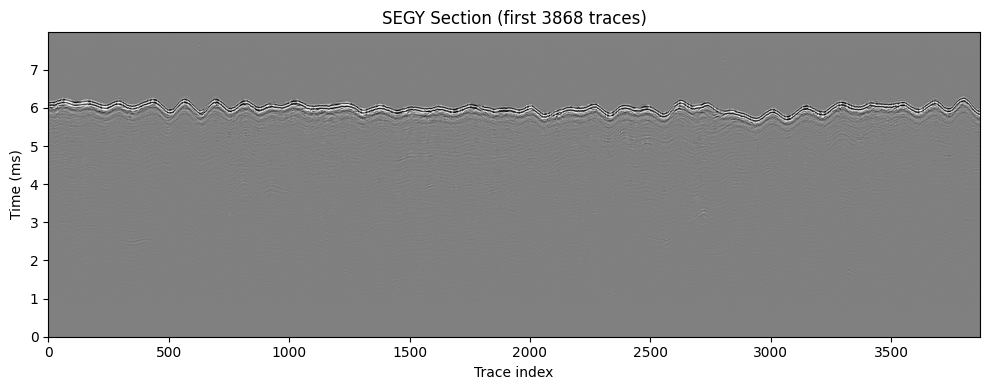

In [34]:
# pip install obspy numpy matplotlib
import numpy as np
import matplotlib.pyplot as plt
from obspy.io.segy.segy import _read_segy

SEGY_PATH = "MMT(2015)_sgy/X-16_20150928_135009_RAW_LF.sgy"  # 改成你的路径

sf = _read_segy(SEGY_PATH, headonly=False)
n_traces = len(sf.traces)
print("Trace count:", n_traces)

trace_index = 2570
n = 3868
# ---- 安全地获取采样间隔 dt（毫秒）----
def get_dt_ms(segfile, fallback_ms=1.0):
    # 1) 二进制文件头（最常见）
    try:
        dt = segfile.binary_file_header.sample_interval_in_microseconds
        if dt and dt > 0:
            return dt / 1000.0
    except Exception:
        pass
    # 2) stats.delta（有些文件会填）
    try:
        dt = segfile.traces[0].stats.delta  # 秒
        if dt and dt > 0:
            return dt * 1000.0
    except Exception:
        pass
    # 3) 兜底：给个合理默认值（仅用于坐标轴）
    print(f"[WARN] No dt in headers; using fallback {fallback_ms} ms for plotting axis.")
    return fallback_ms

dt_ms = get_dt_ms(sf)

# ---- 图1：第一道（竖着显示）----
   # 想看的 trace 号（从 0 开始）
tr = sf.traces[trace_index].data.astype(np.float32)
t = np.arange(tr.size) * dt_ms

plt.figure(figsize=(4, 7))
plt.plot(tr, t, linewidth=0.8)
plt.gca().invert_yaxis()
plt.xlabel("Amplitude")
plt.ylabel("Time (ms)")
plt.title(f"Trace {trace_index+1} (vertical)")  # +1 显示成自然数编号
plt.tight_layout()
plt.show()

# ---- 组剖面：补齐变长道后显示前 500 道 ----
lengths = [tr.data.size for tr in sf.traces]
ns = max(lengths)
n_show = min(n, n_traces)
section = np.zeros((ns, n_show), dtype=np.float32)

for i in range(n_show):
    d = sf.traces[i].data.astype(np.float32)
    section[:d.size, i] = d  # 不足补0

times_ms = np.arange(ns) * dt_ms

# 简单归一化
p99 = np.percentile(np.abs(section), 99)
if p99 > 0:
    section = np.clip(section / p99, -1, 1)

plt.figure(figsize=(10, 4))
extent = [0, n_show, 0, times_ms[-1]]  # 上0ms，下更大
plt.imshow(section, aspect='auto', extent=extent, cmap="gray")
plt.xlabel("Trace index")
plt.ylabel("Time (ms)")
plt.title(f"SEGY Section (first {n_show} traces)")
plt.tight_layout()
plt.show()

Trace count: 3868


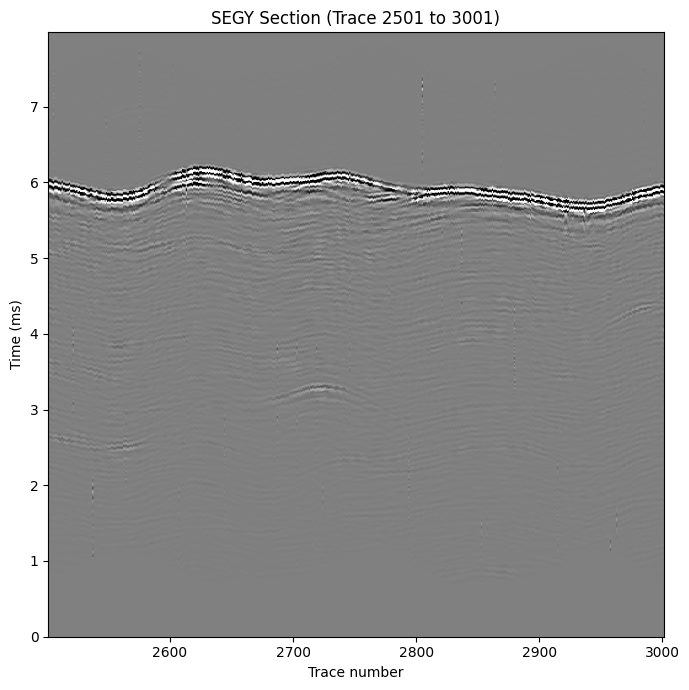

In [42]:
# pip install obspy numpy matplotlib
import numpy as np
import matplotlib.pyplot as plt
from obspy.io.segy.segy import _read_segy

SEGY_PATH = "MMT(2015)_sgy/X-16_20150928_135009_RAW_LF.sgy"  # 改成你的路径

sf = _read_segy(SEGY_PATH, headonly=False)
n_traces = len(sf.traces)
print("Trace count:", n_traces)

# ---- 安全地获取采样间隔 dt（毫秒）----
def get_dt_ms(segfile, fallback_ms=1.0):
    try:
        dt = segfile.binary_file_header.sample_interval_in_microseconds
        if dt and dt > 0:
            return dt / 1000.0
    except: pass
    try:
        dt = segfile.traces[0].stats.delta  # s
        if dt and dt > 0:
            return dt * 1000.0
    except: pass
    print(f"[WARN] No dt in headers; using fallback {fallback_ms} ms for plotting axis.")
    return fallback_ms

dt_ms = get_dt_ms(sf)

# ---- 设置 trace 范围 ----
start_trace = 2500   # 起始 trace 编号（从 0 开始）
end_trace   = 3000   # 结束 trace 编号（从 0 开始，包含它）
trace_range = range(start_trace, min(end_trace+1, n_traces))
n_show = len(trace_range)

# ---- 计算最大采样点数，用来补齐 ----
lengths = [sf.traces[i].data.size for i in trace_range]
ns = max(lengths)
section = np.zeros((ns, n_show), dtype=np.float32)

for j, idx in enumerate(trace_range):
    d = sf.traces[idx].data.astype(np.float32)
    section[:d.size, j] = d  # 不足补 0

times_ms = np.arange(ns) * dt_ms

# 简单归一化（为了显示效果）
p99 = np.percentile(np.abs(section), 99)
if p99 > 0:
    section = np.clip(section / p99, -1, 1)

# ---- 画剖面 ----
plt.figure(figsize=(7, 7))
extent = [start_trace+1, end_trace+1, 0, times_ms[-1]]  # 横坐标用真实 trace number
plt.imshow(section, aspect='auto', extent=extent, cmap="gray")
plt.xlabel("Trace number")
plt.ylabel("Time (ms)")
plt.title(f"SEGY Section (Trace {start_trace+1} to {end_trace+1})")
plt.tight_layout()
plt.show()

Trace count: 3868


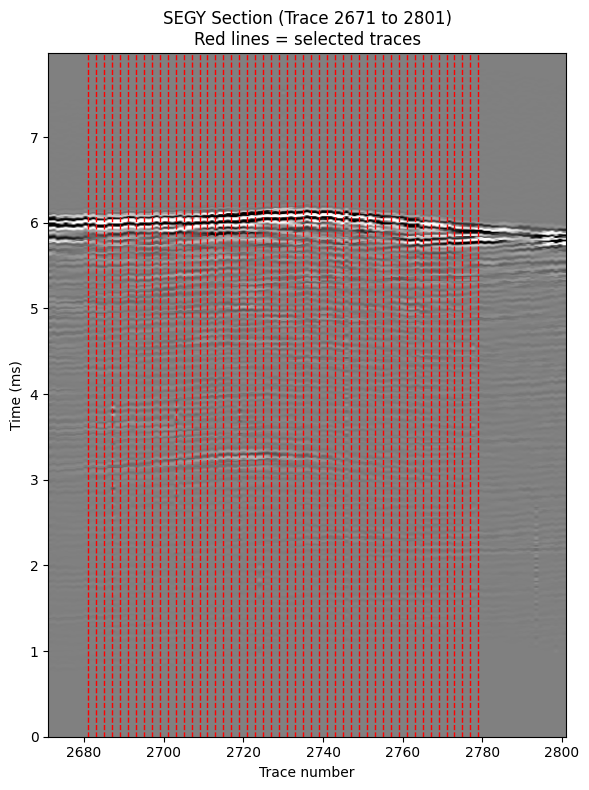

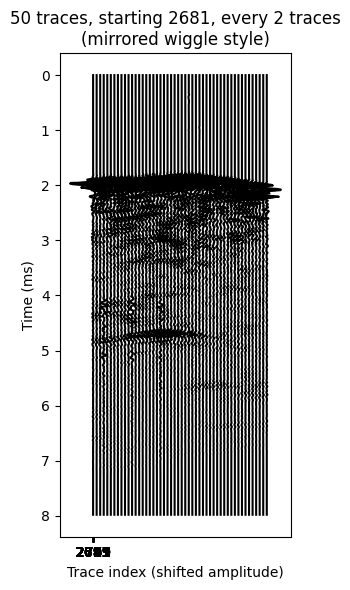

In [101]:
# pip install obspy numpy matplotlib
import numpy as np
import matplotlib.pyplot as plt
from obspy.io.segy.segy import _read_segy

SEGY_PATH = "MMT(2015)_sgy/X-16_20150928_135009_RAW_LF.sgy"  # 改成你的路径
sf = _read_segy(SEGY_PATH, headonly=False)
n_traces = len(sf.traces)
print("Trace count:", n_traces)

# ---- 获取采样间隔 dt（毫秒）----
def get_dt_ms(segfile, fallback_ms=1.0):
    try:
        dt = segfile.binary_file_header.sample_interval_in_microseconds
        if dt and dt > 0:
            return dt / 1000.0
    except: pass
    try:
        dt = segfile.traces[0].stats.delta  # s
        if dt and dt > 0:
            return dt * 1000.0
    except: pass
    print(f"[WARN] No dt in headers; using fallback {fallback_ms} ms.")
    return fallback_ms

dt_ms = get_dt_ms(sf)

# ---- 大剖面范围 ----
start_trace = 2670
end_trace   = 2800
trace_range = range(start_trace, min(end_trace+1, n_traces))
n_show = len(trace_range)

# 计算最大采样点数
lengths = [sf.traces[i].data.size for i in trace_range]
ns = max(lengths)
section = np.zeros((ns, n_show), dtype=np.float32)

for j, idx in enumerate(trace_range):
    d = sf.traces[idx].data.astype(np.float32)
    section[:d.size, j] = d

times_ms = np.arange(ns) * dt_ms

# 归一化
p99 = np.percentile(np.abs(section), 99)
if p99 > 0:
    section = np.clip(section / p99, -1, 1)

# ---- 设置单道波形参数 ----
trace_start = 2680   # 起始 trace
step = 2           # 间隔
n_waveforms = 50     # 总共画多少条
trace_indices = [trace_start + i*step for i in range(n_waveforms)]

# ---- 剖面 + 红线 ----
plt.figure(figsize=(6, 8))
extent = [start_trace+1, end_trace+1, 0, times_ms[-1]]
plt.imshow(section, aspect='auto', extent=extent, cmap="gray")
for idx in trace_indices:
    if idx < n_traces:
        plt.axvline(idx+1, color='red', linestyle='--', linewidth=1)
plt.xlabel("Trace number")
plt.ylabel("Time (ms)")
plt.title(f"SEGY Section (Trace {start_trace+1} to {end_trace+1})\nRed lines = selected traces")
plt.tight_layout()
plt.show()

# ---- 单道竖直波形 (一行10列) ----
plt.figure(figsize=(3, 6))

for k, idx in enumerate(trace_indices):
    if idx >= n_traces:
        continue
    tr = sf.traces[idx].data.astype(np.float32)
    t = np.arange(tr.size) * dt_ms
    plt.plot(-(tr) + k*5000, t, color="black")
plt.xticks(
    ticks=range(len(trace_indices)), 
    labels=[idx+1 for idx in trace_indices]  # trace 编号
)
plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()   # 👈 加这一行，沿x轴对称

plt.xlabel("Trace index (shifted amplitude)")
plt.ylabel("Time (ms)")
plt.title(f"{n_waveforms} traces, starting {trace_start+1}, every {step} traces\n(mirrored wiggle style)")
plt.tight_layout()
plt.show()



Trace count: 3231


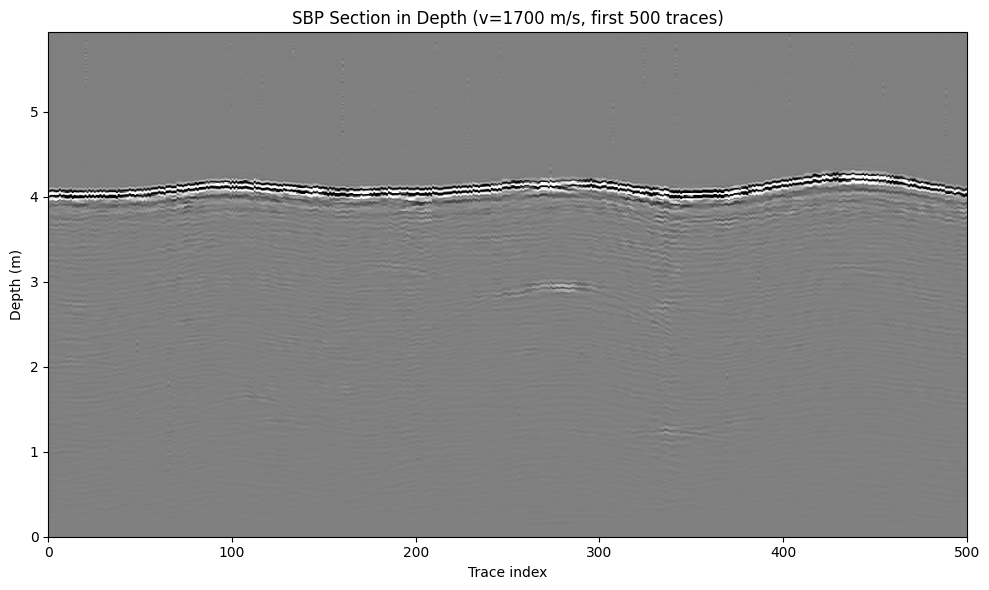

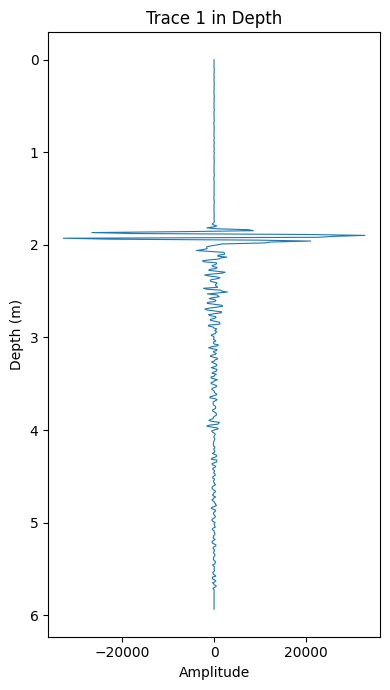

In [26]:
# pip install obspy numpy matplotlib
import numpy as np
import matplotlib.pyplot as plt
from obspy.io.segy.segy import _read_segy

SEGY_PATH = "MMT(2015)_sgy/X-10_20150928_132907_RAW_LF.sgy"   # 改成你的文件路径
VEL_MS = 1700.0                  # 假定声速 (m/s)，例如海水/浅层沉积物
MAX_TRACES_TO_SHOW = 500         # 最多显示多少道

# 读取 SEG-Y（ObsPy 容错好，适合 SBP/Chirp）
sf = _read_segy(SEGY_PATH, headonly=False)
n_traces = len(sf.traces)
print("Trace count:", n_traces)

# ---- 采样间隔 dt（毫秒），按二进制头/trace.stats/回退顺序获取 ----
def get_dt_ms(segfile, fallback_ms=1.0):
    try:
        dt = segfile.binary_file_header.sample_interval_in_microseconds
        if dt and dt > 0:
            return dt / 1000.0
    except: pass
    try:
        dt = segfile.traces[0].stats.delta  # s
        if dt and dt > 0:
            return dt * 1000.0
    except: pass
    print(f"[WARN] No dt in header; using fallback {fallback_ms} ms for axis.")
    return fallback_ms

dt_ms = get_dt_ms(sf)

# ---- 组剖面：把变长道补零到同一长度 ----
lengths = [tr.data.size for tr in sf.traces]
ns = max(lengths)
n_show = min(MAX_TRACES_TO_SHOW, n_traces)
section = np.zeros((ns, n_show), dtype=np.float32)
for i in range(n_show):
    d = sf.traces[i].data.astype(np.float32)
    section[:d.size, i] = d  # 不足部分补0

# ---- 时间轴(ms) → 深度轴(m)： z = v * t / 2 ----
times_ms = np.arange(ns) * dt_ms
times_s  = times_ms / 1000.0
depth_m  = 0.5 * VEL_MS * times_s  # 深度数组，与每一行对应

# ---- 简单归一化便于显示（可选）----
p99 = np.percentile(np.abs(section), 99)
if p99 > 0:
    section = np.clip(section / p99, -1, 1)

# ---- 画剖面：纵轴改为深度(m)，上0、下更大 ----
plt.figure(figsize=(10, 6))
extent = [0, n_show, 0.0, float(depth_m[-1])]  # y轴从0到最大深度
plt.imshow(section, aspect='auto', extent=extent, cmap="gray")
plt.xlabel("Trace index")
plt.ylabel("Depth (m)")
plt.title(f"SBP Section in Depth (v={VEL_MS:.0f} m/s, first {n_show} traces)")
plt.tight_layout()
plt.show()

# ---- 想看某一条道（竖着）也用深度轴 ----
trace_index = 0  # 改成你想看的道号（从0开始）
tr = sf.traces[trace_index].data.astype(np.float32)
z = depth_m[:tr.size]
plt.figure(figsize=(4, 7))
plt.plot(tr, z, linewidth=0.8)
plt.gca().invert_yaxis()  # 上浅下深
plt.xlabel("Amplitude")
plt.ylabel("Depth (m)")
plt.title(f"Trace {trace_index+1} in Depth")
plt.tight_layout()
plt.show()